In [1]:
spark

In [2]:
Oskar()

NameError: name 'Oskar' is not defined

In [ ]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import col, udf, count, explode, concat, when, expr
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("/home/roldanx/appl/oskar/oskar-spark/src/test/resources/platinum_chr22.small.parquet")

TypeError: 'JavaPackage' object is not callable

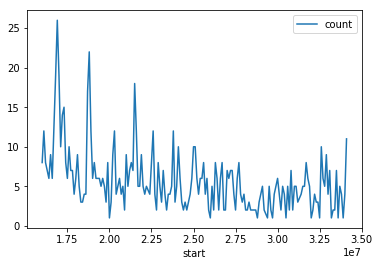

In [13]:
pandaDF = oskar.histogram(df,"start",100000).toPandas()
pandaDF.plot(x = "start", y = "count")

In [9]:
df.createOrReplaceTempView("chr22")
print(oskar.metadata.samples(df))
oskar.hardy_weinberg(df, "hgvauser@platinum:illumina_platinum").select("id", "HWE").show()

# Group by type
df.groupBy("type").count().show()
spark.sql("SELECT type, count(*) FROM chr22 GROUP BY type").show()

## Group by variant
# 1)
df.where("type = 'SNV'").select("reference", "alternate").groupBy("reference", "alternate").count().sort("count", ascending=False).show()
# 2)
df.where(col("type").isin("SNV", "SNP")).select("reference", "alternate").groupBy("reference", "alternate").count().sort("count", ascending=False).show()
# 3)
df.where(df.type.isin("SNV", "SNP")).select(df.reference, df.alternate).groupBy(df.reference, df.alternate).count().sort("count", ascending=False).show()
# 4)
spark.sql("SELECT reference, alternate, count(*) FROM chr22 WHERE type = 'SNV' GROUP BY reference,alternate ORDER BY count(*) DESC").show()

{'hgvauser@platinum:illumina_platinum': ['NA12877', 'NA12878', 'NA12879', 'NA12880', 'NA12881', 'NA12882', 'NA12883', 'NA12884', 'NA12885', 'NA12886', 'NA12887', 'NA12888', 'NA12889', 'NA12890', 'NA12891', 'NA12892', 'NA12893']}
+---------------+--------------------+
|             id|                 HWE|
+---------------+--------------------+
|22:16054454:C:T|                 1.0|
|22:16065809:T:C|                 1.0|
|22:16077310:T:A|  0.9254727474972191|
|22:16080499:A:G|                 1.0|
|22:16084621:T:C|                 1.0|
|22:16091610:G:T|                 1.0|
|22:16096040:G:A|  0.4746014089729329|
|22:16099957:C:T|0.016007636455477054|
|22:16100462:A:G|0.001011008618240...|
|22:16105660:G:A|  0.3037449017426771|
|22:16112391:G:A| 0.17718452601656157|
|22:16114913:A:T|  0.6855353685164587|
|22:16127471:A:-|                 1.0|
|22:16134019:G:T| 0.17718452601656157|
|22:16138943:C:G|  0.6855353685164587|
|22:16144239:T:C| 0.18181818181818182|
|22:16147398:G:A|0.00101122459

In [28]:
oskar.stats(df, cohort="AFR", samples=['NA12877', 'NA12878']).selectExpr("id", "studies[0].stats['AFR'] as stats").selectExpr("id", "stats.*").show(10,False)

+---------------+-----------+--------------+--------------+-------------+-------------+--------------------+------------------------------------+------------------+--------------------+----+----+---------+-----------+
|id             |alleleCount|refAlleleCount|altAlleleCount|refAlleleFreq|altAlleleFreq|genotypeCount       |genotypeFreq                        |missingAlleleCount|missingGenotypeCount|maf |mgf |mafAllele|mgfGenotype|
+---------------+-----------+--------------+--------------+-------------+-------------+--------------------+------------------------------------+------------------+--------------------+----+----+---------+-----------+
|22:16054454:C:T|-1         |0             |0             |-1.0         |-1.0         |[./. -> 2]          |[]                                  |3                 |1                   |-1.0|-1.0|null     |null       |
|22:16065809:T:C|2          |1             |1             |0.5          |0.5          |[0/1 -> 1, ./. -> 1]|[0/0 -> 0.0, 0/1 -> 

In [16]:
df.select("id", "chromosome", "start", "end").filter(df.chromosome == 22).filter(df.start > 17000000).filter(df.end < 17500000).show(5)
df.select("id", "chromosome", "start", "end").filter(col("chromosome") == 22).filter(col("start") > 17000000).filter(col("end") < 17500000).show(5)
df.select("id", "chromosome", "start", "end").filter((col("chromosome") == 22) & (col("start") > 17000000) & (col("end") < 17500000)).show(5)
df.select("id", "chromosome", "start", "end").filter(expr("chromosome =='22' AND start > 17000000 AND end < 17500000")).show(5)
df.select("id", "chromosome", col("start").alias("start"), "end").filter(col("start") > 17000000).show(5)
# spark.sql("SELECT id,chromosome,start,end FROM platinum WHERE chromosome =='22' AND start > 17000000 AND end < 17500000").show(5)

+---------------+----------+--------+--------+
|             id|chromosome|   start|     end|
+---------------+----------+--------+--------+
|22:17001352:C:G|        22|17001352|17001352|
|22:17002352:C:A|        22|17002352|17002352|
|22:17004097:G:A|        22|17004097|17004097|
|22:17011943:G:C|        22|17011943|17011943|
|22:17012760:G:A|        22|17012760|17012760|
+---------------+----------+--------+--------+
only showing top 5 rows

+---------------+----------+--------+--------+
|             id|chromosome|   start|     end|
+---------------+----------+--------+--------+
|22:17001352:C:G|        22|17001352|17001352|
|22:17002352:C:A|        22|17002352|17002352|
|22:17004097:G:A|        22|17004097|17004097|
|22:17011943:G:C|        22|17011943|17011943|
|22:17012760:G:A|        22|17012760|17012760|
+---------------+----------+--------+--------+
only showing top 5 rows

+---------------+----------+--------+--------+
|             id|chromosome|   start|     end|
+---------

In [8]:
df.select(df.id, genes("annotation").alias("gene")).filter(array_contains("gene", "NBEAP3")).show()
df.selectExpr("id", "genes(annotation) AS gene").filter(array_contains("gene", "NBEAP3")).show()

+---------------+--------------------+
|             id|                gene|
+---------------+--------------------+
|22:16096040:G:A|            [NBEAP3]|
|22:16099957:C:T|            [NBEAP3]|
|22:16100462:A:G|            [NBEAP3]|
|22:16105660:G:A|            [NBEAP3]|
|22:16112391:G:A|            [NBEAP3]|
|22:16114913:A:T|            [NBEAP3]|
|22:16127471:A:-|[LA16c-60H5.7, NB...|
+---------------+--------------------+

+---------------+--------------------+
|             id|                gene|
+---------------+--------------------+
|22:16096040:G:A|            [NBEAP3]|
|22:16099957:C:T|            [NBEAP3]|
|22:16100462:A:G|            [NBEAP3]|
|22:16105660:G:A|            [NBEAP3]|
|22:16112391:G:A|            [NBEAP3]|
|22:16114913:A:T|            [NBEAP3]|
|22:16127471:A:-|[LA16c-60H5.7, NB...|
+---------------+--------------------+



In [9]:
pandas = df.where("type = 'SNV'") \
    .select("reference", "alternate") \
    .groupBy("reference", "alternate") \
    .count() \
    .sort("count", ascending=False) \
    .select(concat(col("reference"), lit(" -> "), col("alternate")).alias("variant"), col("count")).show()

+-------+-----+
|variant|count|
+-------+-----+
| C -> T|  142|
| G -> A|  138|
| A -> G|  120|
| T -> C|  111|
| C -> A|   63|
| A -> C|   53|
| G -> T|   53|
| T -> A|   52|
| T -> G|   48|
| A -> T|   47|
| C -> G|   34|
| G -> C|   33|
+-------+-----+

